# Final project 
## Task 2: Biodiversity Intactness Index change in Phoenix, AZ
#### Author: Sofia Rodas
#### Date: December 6, 2025

- Final project GitHub repository: https://github.com/sofiiir/task2-biodiversity-intactness

## About

**1. Purpose:** 
- This notebook explores how the increase in development in the Phoenix area is influencing the Biodiversity Intactness Index (BII) from 2017 to 2020 to see how urbanization influences overall ecological health.


**2.  Highlights:** 

- Explore catalogue data and metadata

- Clip raster data

- Visualize Biodiversity Intactness Index (BII) changes

**3. Datasets descriptions:** 

- **Catalogue Biodiversity Intactness Index (BII):** BII data was downloaded through [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). This dataset has BII data from the years 2017 to 2020. This data is publicly available.

- **Arizona Shapefile:** A Tiger/Line Shapefile with 2023 Arizona boundaries was used for the Phoenix city boundaries. This data is publicly available through the U.S. Census Bureau.  

**4. References:** 

- C. Galaz Garcia and A. Adams, EDS 220 - Working with Environmental Datasets. (n.d.) Available: https://meds-eds-220.github.io/MEDS-eds-220-course/. [Accessed November 17, 2025]

- F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” (Aug. 2022.) Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf [Accessed: Dec. 6, 2025]

- Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. Microsoft Open Source. (Oct. 28, 2022). Available: https://doi.org/10.5281/zenodo.7261897 [Accessed: Dec. 6, 2025]

- U.S. Department of Commerce, U.S. Census Bureau, Geography Division, Geospatial Products Branch. (2023). Available: https://catalog.data.gov/dataset/tiger-line-shapefile-2023-state-arizona-az-county-subdivision [Accessed: Dec. 6, 2025]

- Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post. (Aug. 2021). Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Dec. 6, 2025]


In [1]:
# Import necessary libraries
import os
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import contextily as ctx

import matplotlib.pyplot as plt

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

### Biodiversity Intactness Index (BII) Time Series 

The BII raster information is downloaded through Microsoft Planetary Computer STAC catalog. This catalogue is accessed through the `pystac_client` library.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the bio-diversity collection
BII_collection = catalog.get_child('io-biodiversity')
BII_collection

Number of collections: 126


<CollectionClient id=io-biodiversity>

The temporal range is used to narrow the scope of the search from the catalogue below.

In [3]:
# Temporal range of interest 
time_range = "2017-01-01/2020-12-31"

The following bounding box coordinates are for Phoenix. This `bbox` is used to access the appropriate information from the `io-diversity` catalogue.

In [4]:
# Set bbox
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [5]:
# Catalog search bio-diversity collection
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)

# Get items from search
items = search.item_collection()

# Determine number of items in search
len(items)

4

We can look at the `items` metadata to find what features we need for this analysis. Year information is located `0` under the `properties` tab. Feature `0` corresponds with 2020. Feature `3` corresponds with 2017.

In [6]:
# View items metadata
items

In [7]:
# Get first item in the catalog search
item_2020 = items[0]
item_2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [8]:
# Get fourth item in the catalog search
item_2017 = items[3]
item_2017

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

In [9]:
# View the assets to assess what asset to reference when saving the data
item_2020.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-06T07%3A03%3A50Z&se=2025-12-07T07%3A48%3A50Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-06T05%3A10%3A42Z&ske=2025-12-13T05%3A10%3A42Z&sks=b&skv=2025-07-05&sig=/P/qztwGsf0nLxhGwjwirVf5FdNz%2BS3tMthC2S1PvVs%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

In [10]:
# Save the data for BII 2020
bio_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [11]:
# Save the data for BII 2017
bio_2017= rioxr.open_rasterio(item_2017.assets['data'].href)

# Arizona Data
The Arizona shapefile was downloaded from the Census Bureaus Tiger Files. It is read in with `geoPandas` since it is a vector data.

In [12]:
# Load in Arizona shapefile
fp_az = os.path.join('data', 'tl_2023_04_cousub', 'tl_2023_04_cousub.shp')
az = gpd.read_file(fp_az)

<Axes: >

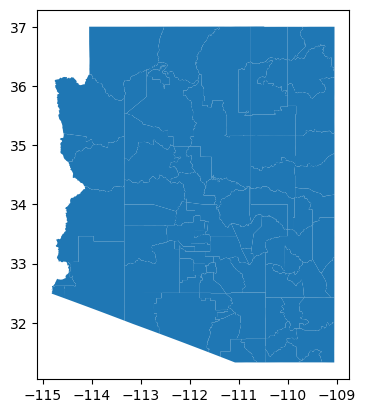

In [13]:
# Initial plot exploration of Arizona shapefile
az.plot()

In [14]:
# View the first 5 rows of the Arizona df
az.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231050070,44656143,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [15]:
# Check the data types of all of the columns
az.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

The `NAME` column contains the names of cities. This analysis is focusing on  BII in Phoenix so let's subset for Phoenix.

In [16]:
# Subset for Phoenix
phoenix = az[az['NAME'] == 'Phoenix']

<Axes: >

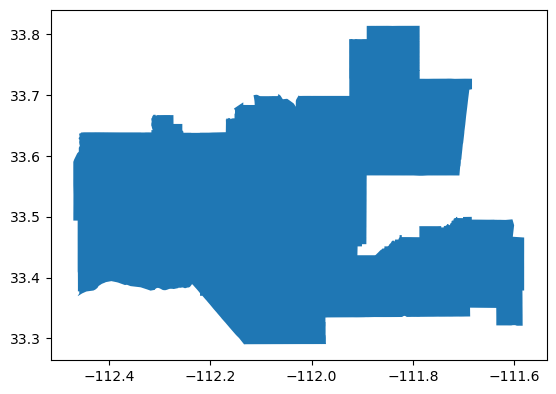

In [17]:
# Plot Phoenix for an initial exploration
phoenix.plot()

### CRS matching
Let's make all of the CRS match for all of the maps and raster data to make all of the other steps smoother . 

In [18]:
# Check if the CRS already match
phoenix.crs == bio_2020.rio.crs

False

In [19]:
# Change the Phoenix CRS to the CRS of the raster data 
phoenix = phoenix.to_crs(crs = bio_2020.rio.crs)

In [20]:
# Create assert statements that confirm the CRS match
assert phoenix.crs == bio_2020.rio.crs
assert phoenix.crs == bio_2017.rio.crs

### Map Phoenix with a basemap 

Text(0.5, 1.0, 'Phoenix boundaries')

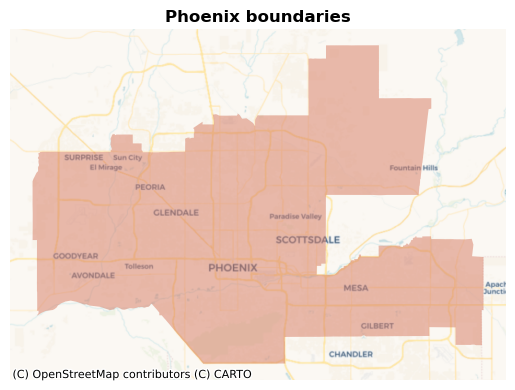

In [21]:
# Set a figure plot
fig, ax = plt.subplots()

# Turn off axis
ax.axis('off')

# Plot Phoenix with reduced opacity
phoenix.plot(ax = ax,
             alpha = 0.5,
             color = '#D77A61')

# Add basemap
ctx.add_basemap(ax = ax, 
                crs = bio_2020.rio.crs,
                source=ctx.providers.CartoDB.Voyager)

# Add title
ax.set_title('Phoenix boundaries', fontsize = 12, fontweight = 'bold')

## Clip BII raster to the Phoenix area

This analysis is only interested in the BII values for the Phoenix area. Subset the BII raster data to the Phoenix boundaries. 

In [22]:
# Clip the raster data with the Phoenix shape geometry
bio_2017 = bio_2017.rio.clip(phoenix.geometry, phoenix.crs)
bio_2020 = bio_2020.rio.clip(phoenix.geometry, phoenix.crs)

Let's plot these to make sure the rasters only cover Phoenix and get a visual of what the difference between 2017 and 2020 might look like. 

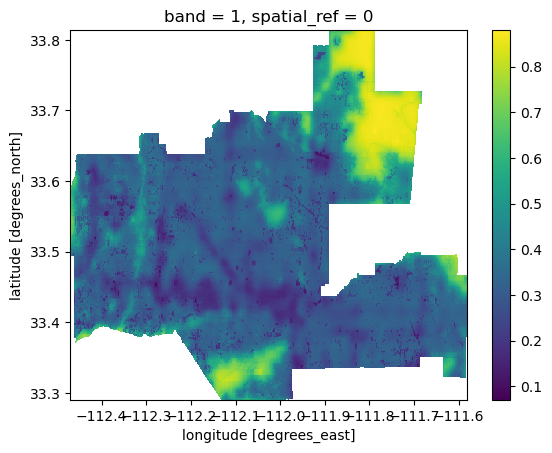

In [23]:
# Phoenix 2017 BII data
bio_2017.plot()

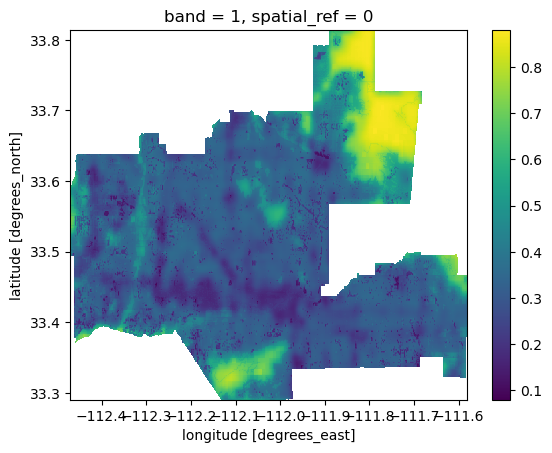

In [24]:
# Phoenix 2020 BII plot
bio_2020.plot()

## Percentage BII
Calculate the percentage of area in the Phoenix area where BII is 0.75 for 2017 and 2020.

In [25]:
# Select for only where 2017 BII data is above 0.75
bio_17_75 = bio_2017 >= 0.75

# Calculate the percentage of area of Phoenix with a BII of at least 0.75 in  2017
percentage_17 = bio_17_75.sum()/ bio_17_75.count() * 100


print(f"In 2017, the percentage of area in the Phoenix subdivision with a BII of 0.75 or greater is {round(percentage_17.values.item(), 2)} percent.")

In 2017, the percentage of area in the Phoenix subdivision with a BII of 0.75 or greater is 4.18 percent.


In [26]:
# Select for only where 2020 BII data is above 0.75
bio_20_75 = bio_2020 >= 0.75

# Calculate the percentage of area of Phoenix with a BII of at least 0.75 in  2017
percentage_20= bio_20_75.sum()/ bio_20_75.count() * 100


print(f"In 2020, the percentage of area in the Phoenix subdivision with a BII of 0.75 or greater is {round(percentage_20.values.item(), 2)} percent.")

In 2020, the percentage of area in the Phoenix subdivision with a BII of 0.75 or greater is 3.81 percent.


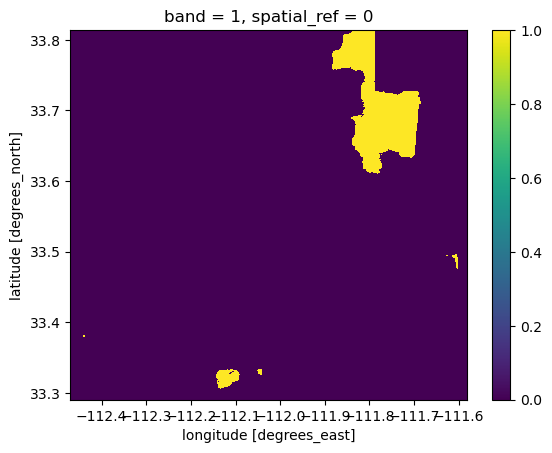

In [27]:
# Initial visualization of 2017 BII data above 75
bio_17_75.plot()

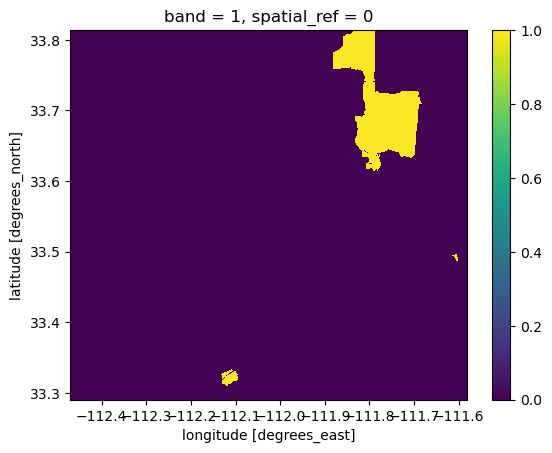

In [28]:
# Initial visualization of 2020 BII data above 75
bio_20_75.plot()

## BII Greater or Equal to 0.75 Loss from 2017 to 2020 Visualization

The areas with a BII greater than or equal to 0.75 in the Phoenix area was reduced. Let's visualize the reduction to see where the losses occured. This visualization requires raster algebra.

In [29]:
# Create intgers so that raster algebra can be performed on the cell values
bio_17_int = bio_17_75.astype(int)
bio_20_int = bio_20_75.astype(int)

In [30]:
# Calculate the loss from 2017 to 2020
loss = bio_17_int - bio_20_int

Loss is a raster of zeros and ones. The zeros signify that the BII did not change. The values that are greater than zero signify that the BII was equal to or greater than 0.75 in 2017 and not in 2020. Therefore, the zeros are unnecessary for plotting the loss and would cover the underlying raster.

In [31]:
# Subset the loss raster to only locations where the values are not zero
loss = loss.where(loss != 0)

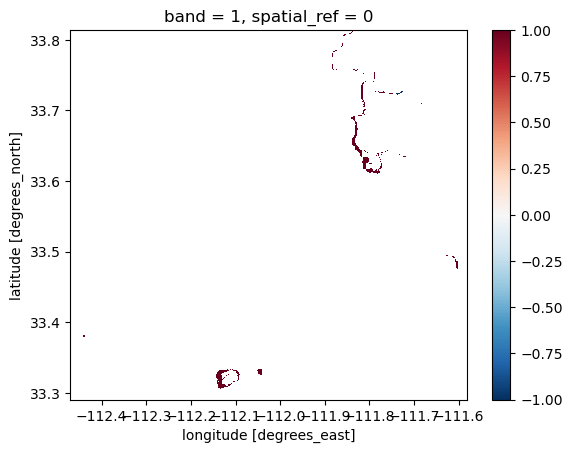

In [32]:
# Initial exploration of the loss values
loss.plot()

Create a visualization showing where Biodiversity Intactness Index is lost with a basemap. 

Text(0.5, 0.98, 'Biodiversity Intactness Index (BII)')

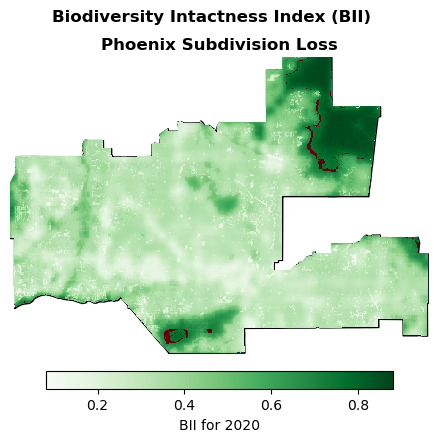

In [41]:
# Set the figure plot
fig, ax = plt.subplots()

# Turn off axis values
ax.axis('off')

# Add the Phoenix area boundary
phoenix.plot(ax=ax, 
             edgecolor = "black")

# Plot a base layer that shows BII 
bio_2020.plot(ax = ax,
              cmap = 'Greens',
              add_colorbar = True,
              cbar_kwargs={"shrink": 0.7,
                           "label": "BII for 2020",
                           "orientation": "horizontal", # change orientation
                           "pad": 0.05})

# Add the BII loss 
loss.plot(ax = ax,
          cmap = "Reds",
          add_colorbar = False)


ax.set_title('Phoenix Subdivision Loss', fontsize = 12, fontweight = 'bold')
fig.suptitle('Biodiversity Intactness Index (BII)', fontsize = 12, fontweight = 'bold')


### Map Analysis
The Phoenix Area in Arizona is losing areas where the Biodiversity Intactness Index is greater than or equal to 0.75. The loss is shown in red on the map above. These areas are on the outskirts of the Phoenix area signifiying urban sprawl is likely occuring in areas that have been historically less densely populated. This loss is alarming since those areas likely act as havens for wildlife and ecosystems to thrive. There is a push for urban areas to centralize their living areas to leave more space available for conservation with the possibility of creating cooridors for wildlife and preserve ecological niches. 

# References

- C. Galaz Garcia and A. Adams, EDS 220 - Working with Environmental Datasets. (n.d.) Available: https://meds-eds-220.github.io/MEDS-eds-220-course/. [Accessed November 17, 2025]

- F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” (Aug. 2022.) Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf [Accessed: Dec. 6, 2025]

- Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. Microsoft Open Source. (Oct. 28, 2022). Available: https://doi.org/10.5281/zenodo.7261897 [Accessed: Dec. 6, 2025]

- U.S. Department of Commerce, U.S. Census Bureau, Geography Division, Geospatial Products Branch. (2023). Available: https://catalog.data.gov/dataset/tiger-line-shapefile-2023-state-arizona-az-county-subdivision [Accessed: Dec. 6, 2025]

- Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post. (Aug. 2021). Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Dec. 6, 2025]

